# Message passing neural network for segment classification on 2D toy data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

In [1]:
# System imports
from __future__ import print_function
from timeit import default_timer as timer

# Externals
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Local imports
from estimator import Estimator

%matplotlib notebook

## Data utilities

In [2]:
def gen_tracks(n, det_r):
    """
    Generate n straight tracks.
    
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)
    """
    xin = np.random.uniform(size=n).astype(np.float32)
    xout = np.random.uniform(size=n).astype(np.float32)
    slopes = (xout - xin) / (det_r[-1] - det_r[0])
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def generate_data(n_events, n_tracks, det_r, sort_first_labels=False):
    n_det_layers = det_r.shape[0]

    # Generate all the tracks we'll need
    tracks = np.stack([gen_tracks(n_events, det_r)
                       for i in range(n_tracks)], axis=1)

    idx0 = np.arange(n_events)[:, None, None]
    idx2 = np.arange(n_det_layers)[None, None, :]

    if sort_first_labels:
        # Sort according to the first hit position, so the labels are
        # consistently defined in terms of the first layer hit order.
        # Note: singleton ('None') idx axes indicate a repeat-broadcast.
        idx1 = tracks[:, :, 0].argsort(axis=1)[:, :, None]
        tracks = tracks[[idx0, idx1, idx2]]

    # Now sort all hits on all layers by their position.
    # This sort index relative to previous sort gives us our hit labels.
    idx = np.argsort(tracks, axis=1)
    x = tracks[[idx0, idx, idx2]]

    # Transpose to shape (n_event, n_layer, n_hit)
    return x.transpose([0,2,1]), idx.transpose([0,2,1])

In [3]:
np_to_torch = lambda x: Variable(torch.from_numpy(x.astype(np.float32)))

## Generate a toy dataset

In [4]:
# Data config
det_r = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=np.float)
n_det_layers = det_r.shape[0]
n_events = 2**15
n_tracks = 4

In [5]:
# Hit position and label
hits_x, hits_y = generate_data(n_events, n_tracks, det_r)
# Hit radius
hits_r = np.broadcast_to(det_r[None, :, None], hits_x.shape)
# Layer number
hits_l = np.broadcast_to(np.arange(n_det_layers)[None, :, None], hits_x.shape)
print(hits_x.shape, hits_y.shape)

# Flattened arrays
x, y, r, l = [a.reshape((n_events, -1)) for a in [hits_x, hits_y, hits_r, hits_l]]
print(map(np.shape, [x, y, r, l]))

(32768, 10, 4) (32768, 10, 4)
[(32768, 40), (32768, 40), (32768, 40), (32768, 40)]


<IPython.core.display.Javascript object>


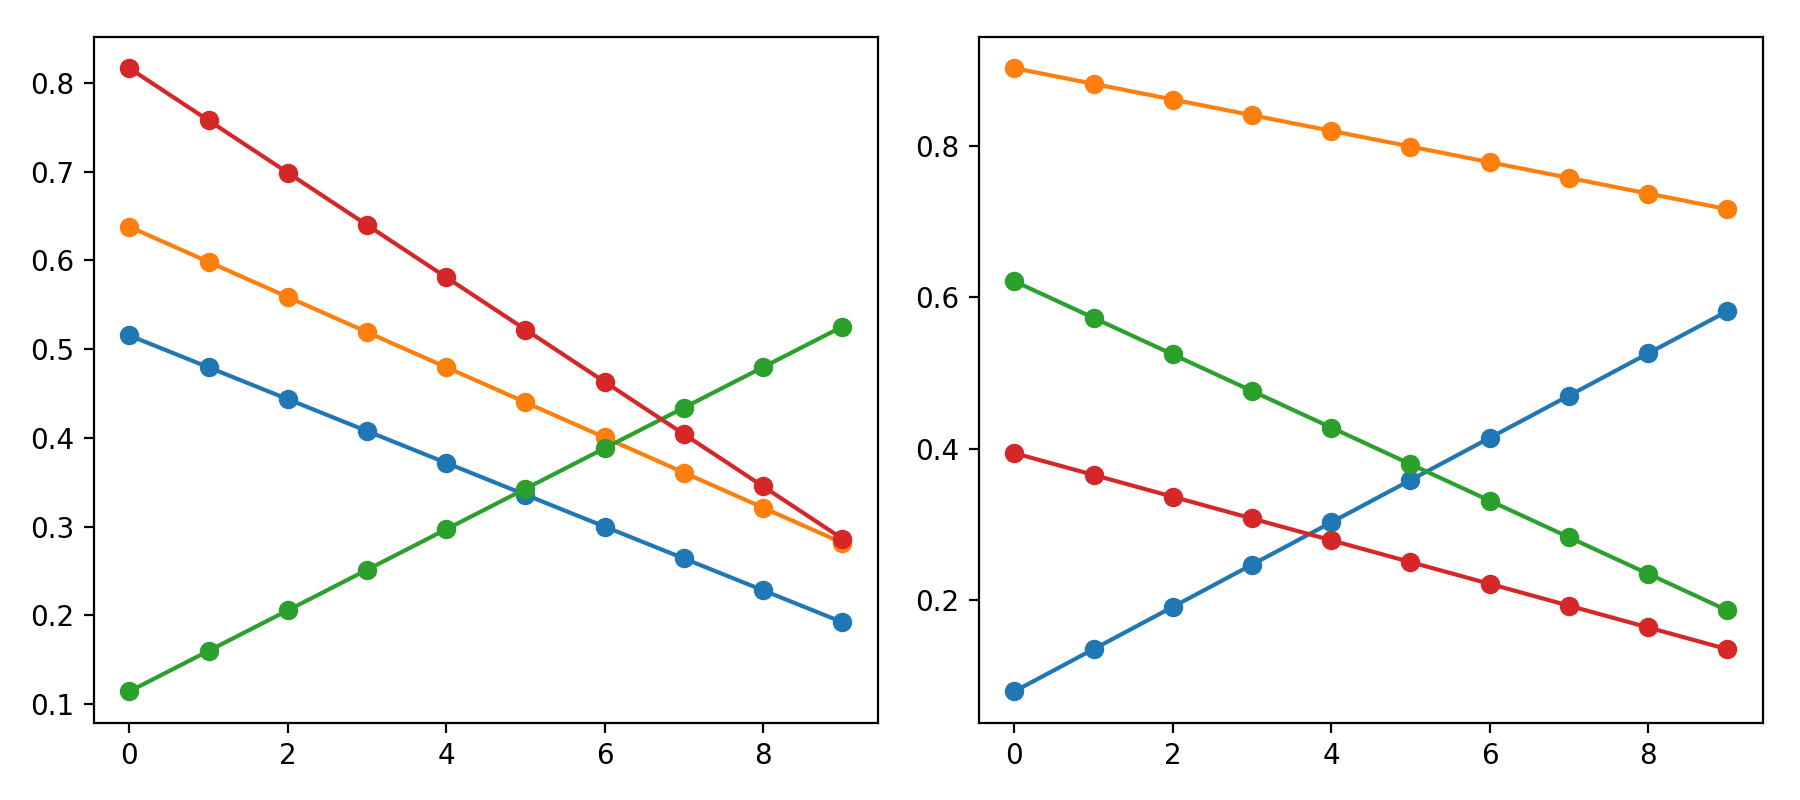

In [6]:
plt.figure(figsize=(9,4))
plt.subplot(121)
i = 0
for yy in np.unique(y[i]):
    idx = (y[i] == yy)
    plt.plot(r[i, idx], x[i, idx], 'o-')

plt.subplot(122)
i = 1
for yy in np.unique(y[i]):
    idx = (y[i] == yy)
    plt.plot(r[i, idx], x[i, idx], 'o-')

plt.tight_layout()

## Build graph representation

To specify the graph, we need to
- enumerate the edges
- construct binary matrices that associate hits onto wedges

We separate out the outgoing edges from incoming edges with two matrices: $\bf R_o$ and $\bf R_i$.

In [7]:
%%time

n_hits = n_tracks * n_det_layers
n_edges = n_tracks**2 * (n_det_layers - 1)

d = l[0,None,:] - l[0,:,None]
e = np.stack(np.where(d==1), axis=1)

Ri = np.zeros((1, n_hits, n_edges), dtype=np.uint16)
Ro = np.zeros((1, n_hits, n_edges), dtype=np.uint16)
Ri[:, e[:,1], np.arange(n_edges)] = 1
Ro[:, e[:,0], np.arange(n_edges)] = 1

Ri = Ri.repeat(n_events, axis=0)
Ro = Ro.repeat(n_events, axis=0)

CPU times: user 65 ms, sys: 297 ms, total: 362 ms
Wall time: 362 ms


In [8]:
# Node features: (events, hits, features)
X = np.stack([x, r], axis=-1)

# Compute edge labels
yo = np.matmul(y[:,None], Ro).squeeze(1)
yi = np.matmul(y[:,None], Ri).squeeze(1)
ey = (yi == yo)

## Define the model

In [9]:
class EdgeNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        B = torch.cat([bo, bi], dim=2)
        return self.network(B).squeeze(-1)

class NodeNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        Rwo = Ro * e[:,None]
        Rwi = Ri * e[:,None]
        mi = torch.matmul(Rwi, bo)
        mo = torch.matmul(Rwo, bi)
        M = torch.cat([mi, mo, X], dim=2)
        return self.network(M)

class SegmentClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(SegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge layers
        self.edge_networks = nn.ModuleList(
            [EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
             for i in range(n_iters)])
        # Setup the node layers
        self.node_networks = nn.ModuleList(
            [NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
             for i in range(n_iters)])
        # Setup the output layers
        self.output_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)

        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_networks[i](H, Ri, Ro)
            H = self.node_networks[i](H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        
        # Apply output network to get final edge classifications
        return self.output_network(H, Ri, Ro)

In [10]:
class FCSegmentClassifier(nn.Module):
    """Fully-connected network version for comparisons"""
    def __init__(self, n_hits, n_segments, input_dim, hidden_dim=32):
        super(FCSegmentClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_hits*input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_segments),
            nn.Sigmoid())
    
    def forward(self, inputs):
        x = inputs[0] # ignore the rest
        x = x.view(x.size(0), -1)
        return self.network(x)

## Train the model

In [11]:
# Model config
hidden_dim = 32
n_iters = 10

In [12]:
# Training config
batch_size = 32
n_epochs = 32
test_frac = 0.2

In [13]:
n_test = int(n_events * test_frac)
n_train = n_events - n_test
n_train, n_test

(26215, 6553)

In [14]:
train_X, test_X = np_to_torch(X[:n_train]), np_to_torch(X[n_train:])
train_y, test_y = np_to_torch(ey[:n_train]), np_to_torch(ey[n_train:])
train_Ri, test_Ri = np_to_torch(Ri[:n_train]), np_to_torch(Ri[n_train:])
train_Ro, test_Ro = np_to_torch(Ro[:n_train]), np_to_torch(Ro[n_train:])

train_inputs = [train_X, train_Ri, train_Ro]
test_inputs = [test_X, test_Ri, test_Ro]

In [15]:
# Construct the model
model = SegmentClassifier(hidden_dim=hidden_dim, n_iters=n_iters)
#model = FCSegmentClassifier(n_hits, n_edges, 2, hidden_dim)

loss_func = nn.BCELoss()
estimator = Estimator(model, loss_func=loss_func)

2018-03-13 09:46:28.377489 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=2, out_features=32)
    (1): Tanh()
  )
  (edge_networks): ModuleList(
    (0): EdgeNetwork(
      (network): Sequential(
        (0): Linear(in_features=68, out_features=32)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1)
        (3): Sigmoid()
      )
    )
    (1): EdgeNetwork(
      (network): Sequential(
        (0): Linear(in_features=68, out_features=32)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1)
        (3): Sigmoid()
      )
    )
    (2): EdgeNetwork(
      (network): Sequential(
        (0): Linear(in_features=68, out_features=32)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1)
        (3): Sigmoid()
      )
    )
    (3): EdgeNetwork(
      (network): Sequential(
        (0): Linear(in_features=68, out_features=32)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1)
 

In [ ]:
estimator.fit(train_inputs, train_y,
              valid_input=test_inputs, valid_target=test_y,
              batch_size=batch_size, n_epochs=n_epochs)

2018-03-13 09:46:36.028334 Training samples: 26215
2018-03-13 09:46:36.028604 Batches per epoch: 820
2018-03-13 09:46:36.028775 Validation samples: 6553
2018-03-13 09:46:36.029096 Epoch 0
2018-03-13 09:49:00.506449   training loss 0.564 time 144.477s
2018-03-13 09:49:27.161293   validate loss 0.558
2018-03-13 09:49:27.161723 Epoch 1
2018-03-13 09:51:48.991938   training loss 0.363 time 141.83s
2018-03-13 09:52:14.780497   validate loss 0.154
2018-03-13 09:52:14.781275 Epoch 2


In [ ]:
# Plot the loss
plt.figure()
plt.plot(estimator.train_losses, label='training set')
plt.plot(estimator.valid_losses, label='validation set')
plt.legend(loc=0);

## Evaluate on the training set

In [ ]:
estimator.model.eval()
# Compute predictions on the full training set
train_pred = estimator.model(train_inputs)

# Training set accuracy
train_matches = ((train_pred > 0.5) == (train_y > 0.5)).data.numpy()
train_matches.mean()

## Evaluate on the test set

In [ ]:
test_preds = estimator.model(test_inputs)

In [ ]:
matches = ((test_preds > 0.5) == (test_y > 0.5)).data.numpy()
print('Test set accuracy:', matches.mean())

In [ ]:
_y = test_y.data.numpy().flatten()
_preds = test_preds.data.numpy().flatten()

# Compute the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(_y, _preds)

In [ ]:
plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(_preds[_y<0.5], label='fake', **binning)
plt.hist(_preds[_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.tight_layout()

## Visualize model predictions on events

I've done this before in a different notebook. I want to draw all the segments colored according to their model score.

In [ ]:
samples = range(16)

fig, axs = plt.subplots(4, 4, figsize=(9,8))
axs = axs.flatten()

# Loop over samples to draw
for i in samples:
    # Pull out the data for this sample
    sample_x, sample_r = test_X[i,:,0].data.numpy(), test_X[i,:,1].data.numpy()
    sample_pred = test_preds[i].data.numpy()
    sample_Ri, sample_Ro = test_Ri[i].data.numpy(), test_Ro[i].data.numpy()

    # Start and end points of the segments
    idxo = np.where(sample_Ro.T>0.5)[1]
    idxi = np.where(sample_Ri.T>0.5)[1]
    r1 = sample_r[idxo]
    r2 = sample_r[idxi]
    x1 = sample_x[idxo]
    x2 = sample_x[idxi]

    # Draw all the hits
    axs[i].scatter(sample_r, sample_x)

    # Draw the segments
    for j in range(n_edges):
        axs[i].plot([r1[j], r2[j]], [x1[j], x2[j]], 'k-', alpha=sample_pred[j])

plt.tight_layout()

## Debugging the model

Let's re-implement the innards of the model and invoke the sub-modules by hand. Check a test sample all the way through and see how the data transforms.